# Qiskit (Yen Lee Loh, 2023-5-5)

## Setup

This is a Markdown cell with LaTeX definitions.  Please run it.
$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$

In [1]:
%%html  
<style>  /* FORMATTING CODE */
h1 { background-color: #AEA; padding: 0.8ex 0.8ex 0.5ex 0.8ex; border: 2px solid #8C8; }
h2 { background-color: #AEE; padding: 0.8ex 0.8ex 0.5ex 0.8ex; border: 2px solid #9CC; }
h3 { background-color: #EEA; padding: 0.8ex 0.8ex 0.5ex 0.8ex; border: 2px solid #CC9; }
</style>

In [2]:
import numpy as np; from numpy import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import regex as re
import qiskit,qiskit_aer
import qiskit.visualization as qisvis
from qiskit.providers.fake_provider import fake_provider
vigoBackend = fake_provider.FakeVigo()
rng = random.default_rng()
mystyle = {'linecolor':'#999', 'displaycolor': {'cx':'#06C', 'ccx':'#06C', 'cswap':'#06C'} }

def bstr(integer, numBits): return bin(integer)[2:].zfill(numBits)
def padCounts(cts, numBits):
  def sanitize(count): return (0 if count==None else count)
  n = numBits
  return {bstr(i,n):sanitize(cts.get(bstr(i,n))) for i in range(2**n)}
def getStatevector (res, statevectorName='statevector'):
  return np.asarray(res.data() [statevectorName])
def getStatevectors (res, pattern='psi'):
  dat = res.data()
  statevectorNames = [key for key in dat.keys() if re.search(pattern, key)]
  statevectorNames.sort()
  #statevectorNames = [key for key in dat.keys() if key[:3]=='psi']
  return np.asarray([dat[statevectorName] for statevectorName in statevectorNames])
def plotStatevector(psi,ax='auto',figsize='auto',vertical=False,cmap=mpl.cm.hsv,tickInterval=1):
  #======== Determine dimensions
  nmax = int(np.log(len(psi)) / np.log(2)) # number of qubits
  lmax = 2**nmax                           # number of states
  probs = np.abs(psi)**2
  phases = np.remainder(np.angle(psi) / (2*np.pi), 1)
  #======== If user hasn't supplied an ax, create one now
  if ax=='auto':
    if figsize=='auto':
      figsize = (2,6) if vertical else (6,1)
    fig,ax = plt.subplots(figsize=figsize)
  #======== Plot
  if vertical:
    for l in range(lmax):
      patch = patches.Rectangle([0,-l-1], probs[l],1, ec='black', fc=cmap(phases[l]))
      ax.add_patch(patch)
    ax.set_yticks([-l-1+.5 for l in range(0,lmax,tickInterval)])
    ax.set_yticklabels([bstr(l,nmax) for l in range(0,lmax,tickInterval)])
    ax.set_ylim(-lmax-.5, .5)
    ax.set_xlim(0, max(probs)*1.1)
  else:
    for l in range(lmax):
      patch = patches.Rectangle([l,0], 1,probs[l], ec='black', fc=cmap(phases[l]))
      ax.add_patch(patch)
    ax.set_xticks([l+.5 for l in range(lmax)])
    ax.set_xticklabels([bstr(l,nmax) for l in range(lmax)])
    ax.set_xlim(-.5, lmax+.5)
    ax.set_ylim(0, max(probs)*1.1)
    
def plotHistogram(counts,ax='auto',figsize='auto',vertical=False,fc='#9cf',textrot=0):
  #======== Pad counts
  if isinstance (counts, dict):
    nmax = len(list(counts.keys()) [0] )
    counts = padCounts(counts,nmax)
    counts = list(counts.values())
  #======== Determine dimensions
  nmax = int(np.log(len(counts)) / np.log(2)) # number of qubits
  lmax = 2**nmax                              # number of states
  ymax = max(counts)
  #======== If user hasn't supplied an ax, create one now
  if ax=='auto':
    if figsize=='auto':
      figsize = (2,6) if vertical else (6,1)
    fig,ax = plt.subplots(figsize=figsize)
  #======== Plot
  if vertical:
    for l in range(lmax):
      c = counts[l]
      patch = patches.Rectangle([0,-l-1], c,1, ec='black', fc=fc)
      ax.add_patch(patch)
      if c>0:
        y = (c+.07*ymax if c<0.9*ymax else c-.07*ymax)
        ax.text (y, -l-1+.5, c, va='center',ha='center')
    ax.set_yticks([-l-1+.5 for l in range(lmax)])
    ax.set_yticklabels([bstr(l,nmax) for l in range(lmax)])
    ax.set_ylim(-lmax-.5, .5)
    ax.set_xlim(0, ymax*1.02)
  else:
    for l in range(lmax):
      c = counts[l]
      patch = patches.Rectangle([l,0], 1,c, ec='black', fc=fc)
      ax.add_patch(patch)
      if c>0:
        y = (c+.07*ymax if c<0.9*ymax else c-.07*ymax)
        ax.text (l+.5, y, c, va='center',ha='center')
    ax.set_xticks([l+.5 for l in range(lmax)])
    ax.set_xticklabels([bstr(l,nmax) for l in range(lmax)])  
    ax.tick_params(axis='x', labelrotation=textrot)
    ax.set_xlim(-.5, lmax+.5)
    ax.set_ylim(0, ymax*1.02)

sim = qiskit_aer.AerSimulator()                         # run this line if you want to use ideal simulator
#sim = qiskit_aer.AerSimulator.from_backend(vigoBackend) # uncomment and run if you want to use a noisy simulator based on IBM's Vigo machine

def initRegister (cir, register, value):
  '''
  Add instructions to circuit <cir> to XOR register <register> with an integer <value>
  '''
  for i in range(register.size):
    if (value>>i)&1:
      cir.x(register[i])

## Basic usage examples

### Simulate circuit and examine final statevector

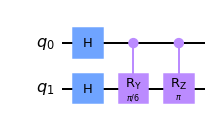

In [3]:
cir = qiskit.QuantumCircuit(2)     # Define quantum circuit with 2 qubits
cir.h(0)                           # Add some gates
cir.h(1)
cir.cry(np.radians(30),0,1)
cir.crz(np.radians(180),0,1)
cir.draw('mpl')                    # Draw circuit

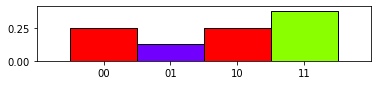

In [4]:
sim = qiskit.Aer.get_backend('statevector_simulator') # Use a simulator that computes the statevector explicitly
exe = qiskit.transpile(cir, sim)   # Boilerplate
job = sim.run(exe, shots=1)        # Run simulation
res = job.result()                 # Boilerplate
psi = getStatevector (res)         # Extract final statevector
plotStatevector (psi)              # Plot statevector

### Simulate circuit and examine counts

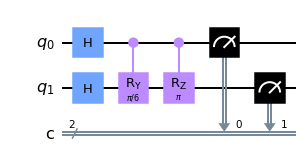

In [5]:
cir = qiskit.QuantumCircuit(2,2)    # Define quantum circuit with 2 qubits and 2 classical bits
cir.h(0)                            # Add some gates
cir.h(1)
cir.cry(np.radians(30),0,1)
cir.crz(np.radians(180),0,1)
cir.measure ([0,1], [0,1])          # Measure all qubits 
cir.draw('mpl')                     # Draw circuit

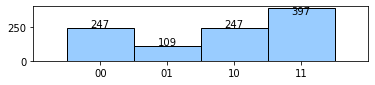

In [6]:
sim = qiskit.Aer.get_backend('aer_simulator')  # Use the default simulator (which may not compute the statevector)
exe = qiskit.transpile(cir, sim)   # Boilerplate
job = sim.run(exe, shots=1000)     # Run simulation
res = job.result()                 # Boilerplate
cts = res.get_counts()
plotHistogram (cts)                # Plot histogram of counts (values of classical register after measurements)

### Visualize evolution of statevector

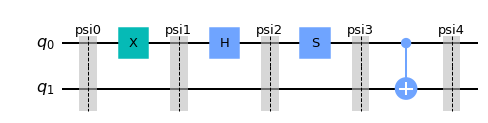

In [7]:
cir = qiskit.QuantumCircuit(2)           # Define quantum circuit with 2 qubits
cir.save_statevector (label='psi0')      # Save initial state as psi0
cir.x(0)                                 # Add NOT (Pauli X) gate
cir.save_statevector (label='psi1')      # Save intermediate state
cir.h(0)                                 # Add Hadamard (H) gate
cir.save_statevector (label='psi2')      # Save intermediate state
cir.s(0)                                 # Add NOT (Pauli X) gate
cir.save_statevector (label='psi3')      # Save final state as psi3
cir.cx(0,1)                              # Add CNOT gate 
cir.save_statevector (label='psi4')      # Save final state as psi3
cir.draw('mpl')                          # Draw circuit

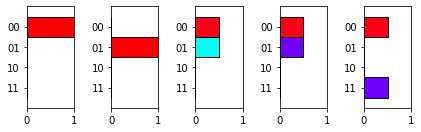

In [8]:
sim = qiskit.Aer.get_backend('statevector_simulator') # Use a simulator that computes the statevector explicitly
exe = qiskit.transpile(cir, sim)     # Boilerplate
job = sim.run(exe, shots=100)        # Run simulation 100 times
res = job.result()                   # Boilerplate
psi = getStatevectors (res)          # Extract statevectors (from last run)
n = len(psi)
fig,axs = plt.subplots (1,n,figsize=(6,2)); fig.tight_layout() 
for i in range(n):
  plotStatevector (psi[i], ax=axs[i], vertical=True,figsize=(1,5))
  axs[i].set_xlim ([0,1])

In the above example:
- The initial state is $\ket{00}$.  
- The X gate acts on this state to produce $\ket{01}$.  
- The H gate then produces $\frac{1}{\sqrt{2}} (\ket{00} - \ket{01})$.  
- The S gate changes the phase whenever the 0th qubit is 1, producing $\frac{1}{\sqrt{2}} (\ket{00} - i\ket{01})$.
- The CX gate maps 01 to 11, so the final state is $\frac{1}{\sqrt{2}} (\ket{00} - i\ket{11})$.

## 4-bit incrementer starting with superposition

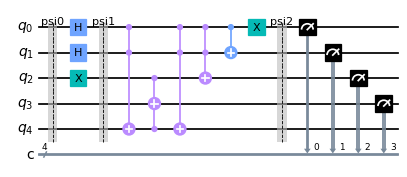

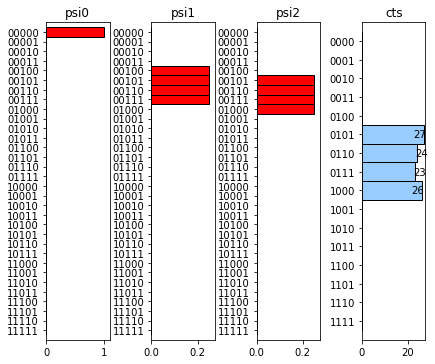

In [9]:
cir = qiskit.QuantumCircuit(5,4)
cir.save_statevector(label='psi0')
cir.h(0); cir.h(1); cir.x(2)
cir.save_statevector(label='psi1')
cir.ccx(0,1,4); cir.ccx(2,4,3); cir.ccx(0,1,4) # q3 ^= q0&q1&q2 (using ancilla q_4)
cir.ccx(0,1,2)                                 # q2 ^= q0&q1
cir.cx(0,1)                                    # q1 ^= q0
cir.x(0)                                       # q0 ^= 1
cir.save_statevector(label='psi2')
cir.measure([0,1,2,3], [0,1,2,3])              # measure q0,q1,q2,q3 and store in c0,c1,c2,c3
fig,ax = plt.subplots (figsize=(12,3))
cir.draw('mpl', justify='left', ax=ax); plt.show()

sim = qiskit.Aer.get_backend('statevector_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=100)
res = job.result()
cts = res.get_counts(exe)
psi = getStatevectors (res, 'psi')
fig,axs = plt.subplots (1,4, figsize=(6,5)); fig.tight_layout() 
ax=axs[0]; plotStatevector(psi[0],ax=ax,vertical=True); ax.set_title ('psi0')
ax=axs[1]; plotStatevector(psi[1],ax=ax,vertical=True); ax.set_title ('psi1')
ax=axs[2]; plotStatevector(psi[2],ax=ax,vertical=True); ax.set_title ('psi2');
ax=axs[3]; plotHistogram(cts,ax=ax,vertical=True); ax.set_title ('cts');

In the above example:
- The initial state is $\ket{\psi_0} = \ket{00000} = \ket{0}$.  
- We use $H_0$ and $H_1$ gates to put qubits $q_0$ and $q_1$ in uniform superpositions.  We use an $X_2$ gate to flip qubit $q_2$.
- The resulting state is $\ket{\psi_1} = \ket{0}\otimes\ket{0}\otimes\ket{1}\otimes\ket{+}\otimes\ket{+}$.
- This is $\ket{\psi_1} = \frac{1}{\sqrt{4}} (\ket{4}+\ket{5}+\ket{6}+\ket{7})$.
- The 4-bit incrementer produces $\ket{\psi_2} = \frac{1}{\sqrt{4}} (\ket{5}+\ket{6}+\ket{7}+\ket{8})$.
- Measuring all qubits gives four possible classical results $(5, 6, 7, 8)$ with equal probability.

## Add constant to 4-bit number (or subtract constant from 4-bit number)

In [72]:
def QFT(n):
  C = qiskit.QuantumCircuit(n, name='    QFT    ')
  for i in reversed(range(n)):
    C.h (i)
    for j in range(i):
      C.cp (np.pi/2**(j+1), i-1-j, i)
  for i in range(n//2): 
    C.swap (i, n-1-i)
  return C.to_instruction()

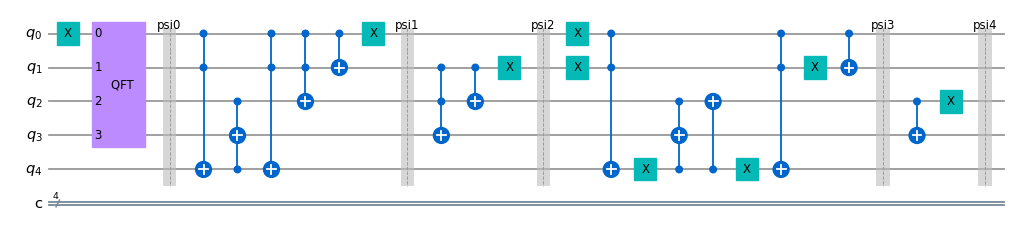

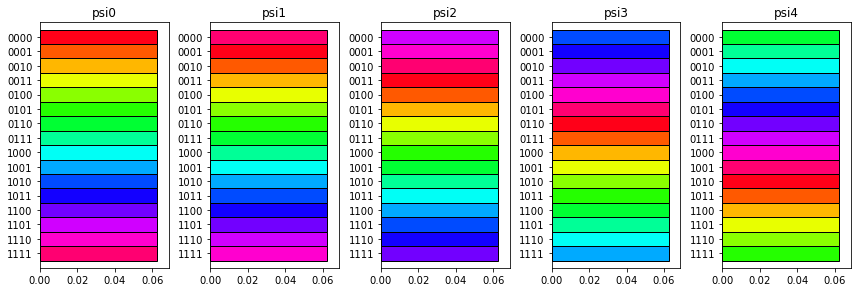

In [101]:
n = 4
na = 1  # ancillas
cir = qiskit.QuantumCircuit(n+na, n)
#======== Prepare nice colors
cir.x(0)
cir.append (QFT(n), range(n))
cir.save_statevector(label='psi0')
#======== Increment by 1
cir.ccx(0,1,4);cir.ccx(2,4,3);cir.ccx(0,1,4);  cir.ccx(0,1,2); cir.cx(0,1); cir.x(0)
cir.save_statevector(label='psi1')
#======== Increment by 2
cir.ccx(1,2,3); cir.cx(1,2); cir.x(1)
cir.save_statevector(label='psi2')
#======== Increment by 3 (=1+2) using 5 CCNOT gates
# cir.ccx(1,2,3); cir.cx(1,2); cir.x(1)
# cir.ccx(0,1,4);cir.ccx(2,4,3);cir.ccx(0,1,4);  cir.ccx(0,1,2); cir.cx(0,1); cir.x(0)
# cir.save_statevector(label='psi3')
#======== Increment by 3 (= 4-1) using 4 CCNOT gates
# cir.cx(2,3); cir.x(2)
# cir.x(0); cir.cx(0,1); cir.ccx(0,1,2); cir.ccx(0,1,4);cir.ccx(2,4,3);cir.ccx(0,1,4);  
# cir.save_statevector(label='psi3')
#======== Increment by 3 using 3 CCNOT gates
cir.x(0); cir.x(1); cir.ccx(0,1,4); cir.x(4)   # c2 ^= x0|x1
cir.ccx(4,2,3)                                 # x3 ^= c2&x2
cir.cx (4,2)                                   # x2 ^= c2
cir.x(4); cir.ccx(0,1,4);  cir.x(1)            # uncompute c2 but then do x0 ^= 1
cir.cx(0,1) # x1 ^= x0
cir.save_statevector(label='psi3')
#======== Increment by 4
cir.cx(2,3); cir.x(2)
cir.save_statevector(label='psi4')
#======== Draw
fig,ax = plt.subplots (figsize=(24,4)); cir.draw('mpl', fold=-1,style=mystyle,justify='left',ax=ax); plt.show()

sim = qiskit.Aer.get_backend('statevector_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=100)
res = job.result()
psi = getStatevectors (res, 'psi') [:, :2**n]    # assume all ancillas are 0
m = len(psi)
fig,axs = plt.subplots (1,m, figsize=(12,4)); fig.tight_layout() 
for i in range(m):
  plotStatevector (psi[i], ax=axs[i], vertical=True)
  axs[i].set_title (f'psi{i}')

## Compare 4-bit number to constant

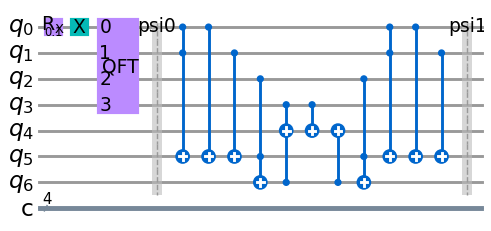

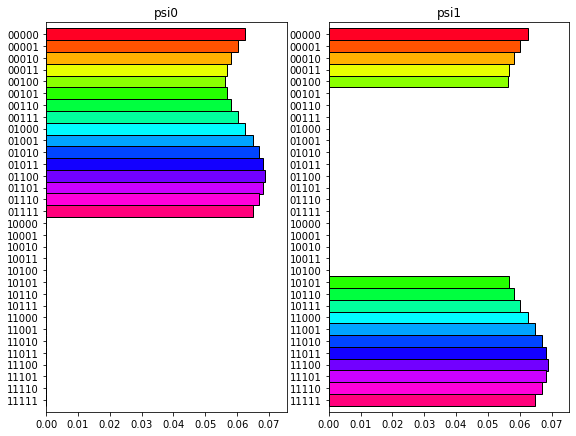

In [150]:
n = 4
na = 3  # ancillas
cir = qiskit.QuantumCircuit(n+na, n)
#======== Prepare nice colors
cir.rx(.1,0);cir.x(0)
cir.append (QFT(n), range(n))
cir.save_statevector(label='psi0')
#======== Compare to 12
#cir.ccx(2,3,4)
#======== Compare to 5
cir.ccx(0,1,5);cir.cx(0,5);cir.cx(1,5) # c2 = x0x1^x0^x1
cir.ccx(2,5,6)                          # c3 ^= c2x2
cir.ccx(3,6,4);cir.cx(3,4);cir.cx(6,4) # compute underflow bit
cir.ccx(2,5,6)                          # c3 ^= c2x2
cir.ccx(0,1,5);cir.cx(0,5);cir.cx(1,5)
#======== Draw
cir.save_statevector(label='psi1')
fig,ax = plt.subplots (figsize=(24,4)); cir.draw('mpl', fold=-1,style=mystyle,justify='left',ax=ax); plt.show()

sim = qiskit.Aer.get_backend('statevector_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=100)
res = job.result()
psi = getStatevectors (res, 'psi') [:,:2**(n+1)]
m = len(psi)
fig,axs = plt.subplots (1,m, figsize=(8,6)); fig.tight_layout() 
for i in range(m):
  plotStatevector (psi[i], ax=axs[i], vertical=True)
  axs[i].set_title (f'psi{i}')

## Doubling modulo odd integer (UNFINISHED)

Suppose $m$ is an odd integer and $x\in \{0,1,2,\dots,m-1\}$.  We wish to compute 

$\quad$
$\begin{align}
x := 2x \text{ mod } m = \begin{cases}
    2x & 2x<m  \\
    2x-m & 2x \geq m         
\end{cases}
\end{align}$

The following algorithm is a way to do this in place.  Let $m$ have $n$ bits and let $x$ have $n+1$ bits.
1. Compute $x := 2x$.  We may do this by rotating $x$ one place to the left (since the MSB of $x$ is originally 0).
2. Compute $x := x - m$.
3. Let $a = x_n$ (i.e., save the MSB of $x$).
4. If $a$, then let $x := x + m$.  That is, undo the subtraction.  At this point, $x$ is the desired result, but $a$ has been changed.
5. We need to uncompute $a$.  We cannot do this via the original route.  However, if originally $x<m$, then the current value of $x$ will be even, otherwise it will be odd.  So we can simply look at the LSB of $x$.  Write $a = a \oplus x_0$.

The table below illustrates what happens for $m=101_2$.
    
      x    2x    a=(x<m)  2x-(1-a)m  LSB
    0000  0000    1        0000      0
    0001  0010    1        0010      0
    0010  0100    1        0100      0
    0011  0110    0        0001      1
    0100  1000    0        0011      1
    

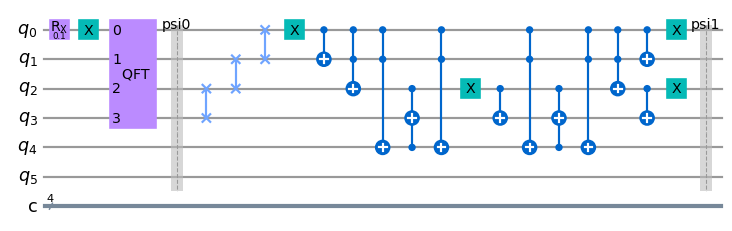

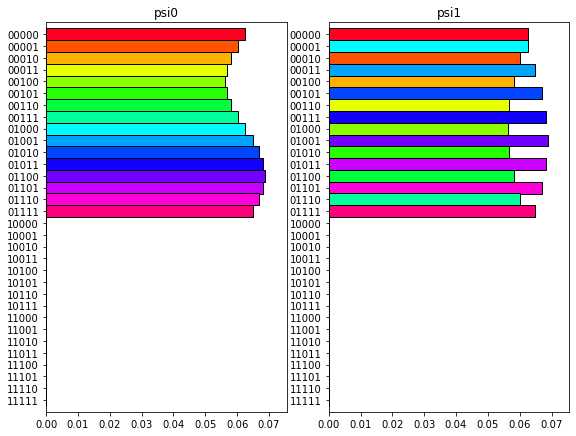

In [154]:
n = 3   # x has n+1 bits
na = 2  # ancillas
cir = qiskit.QuantumCircuit(n+na, n)
#======== Prepare nice colors
cir.rx(.1,0);cir.x(0)
cir.append (QFT(n), range(n))
cir.save_statevector(label='psi0')
#======== x := 2x (rotate left)
cir.swap(3,2);cir.swap(2,1);cir.swap(1,0)
#======== x := x - m (subtract modulus)
cir.x(0);cir.cx(0,1);cir.ccx(0,1,2);cir.ccx(0,1,4);cir.ccx(2,4,3);cir.ccx(0,1,4);     # x -= 1
cir.x(2);cir.cx(2,3);                                                                 # x -= 4
#======== a := x_n  (note that a is bit 4)
cir.cx(3,4)
#======== conditionally add x := x+m:  THIS IS TROUBLESOME.  

#cir.ccx(0,1,4);cir.ccx(2,4,3);cir.ccx(0,1,4);  cir.ccx(0,1,2); cir.cx(0,1); cir.x(0)  # x += 1
#cir.cx(2,3); cir.x(2)                                                                 # x += 4
#======== Draw
cir.save_statevector(label='psi1')
fig,ax = plt.subplots (figsize=(24,4)); cir.draw('mpl', fold=-1,style=mystyle,justify='left',ax=ax); plt.show()

sim = qiskit.Aer.get_backend('statevector_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=100)
res = job.result()
psi = getStatevectors (res, 'psi') [:,:2**(n+1)]
m = len(psi)
fig,axs = plt.subplots (1,m, figsize=(8,6)); fig.tight_layout() 
for i in range(m):
  plotStatevector (psi[i], ax=axs[i], vertical=True)
  axs[i].set_title (f'psi{i}')

## Multiply 4-bit integer by 2 (mod 15)

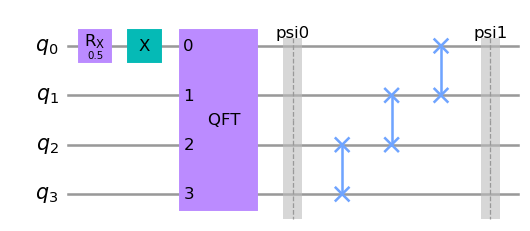

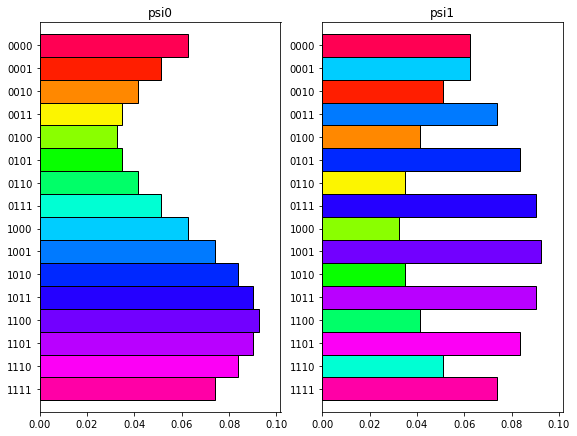

In [149]:
n = 4
cir = qiskit.QuantumCircuit(n)
#======== Prepare nice colors
cir.rx(.5,0);cir.x(0)
cir.append (QFT(n), range(n))
cir.save_statevector(label='psi0')
#======== x = (2*x)%15
cir.swap(3,2);cir.swap(2,1);cir.swap(1,0)
cir.save_statevector(label='psi1')
#======== Draw
fig,ax = plt.subplots (figsize=(12,4)); cir.draw('mpl', fold=-1,style=mystyle,justify='left',ax=ax); plt.show()

sim = qiskit.Aer.get_backend('statevector_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=100)
res = job.result()
psi = getStatevectors (res, 'psi')
m = len(psi)
fig,axs = plt.subplots (1,m, figsize=(8,6)); fig.tight_layout() 
for i in range(m):
  plotStatevector (psi[i], ax=axs[i], vertical=True)
  axs[i].set_title (f'psi{i}')

## n-bit addition

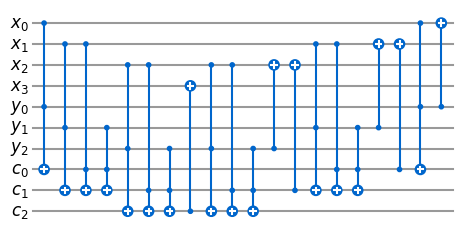

In [209]:
#===============================================================
# Build an n-bit adder
#===============================================================
def makeAdder (n):
  x = qiskit.QuantumRegister(n+1, name='x')  # first addend, extra bit
  y = qiskit.QuantumRegister(n, name='y')    # second addend
  c = qiskit.QuantumRegister(n, name='c')    # carries, which are ancillas (note that c0 is in bit 1 position)
  cir = qiskit.QuantumCircuit(x,y,c, name='        ADD        ')
  for i in range(n):
    cir.ccx (x[i], y[i], c[i])             # compute next carry
    if i>0: cir.ccx (x[i], c[i-1], c[i])   # note that c[-1]==0
    if i>0: cir.ccx (y[i], c[i-1], c[i])   # note that c[-1]==0
  cir.cx (c[n-1], x[n])                    # compute final bit
  for i in reversed(range(n)):
    cir.ccx (x[i], y[i], c[i])           # uncompute intermediate carries
    if i>0: cir.ccx (x[i], c[i-1], c[i])
    if i>0: cir.ccx (y[i], c[i-1], c[i])
    cir.cx (y[i], x[i])                    # update sum (x) based on y
    if i>0: cir.cx (c[i-1], x[i])          # update sum based on carry    
  return cir
#===============================================================
# Build a 3-bit adder
#===============================================================
C = makeAdder(3)
fig,ax = plt.subplots(figsize=(20,4)); C.draw('mpl',ax=ax,fold=-1,reverse_bits=False,justify='none',plot_barriers=False,style=mystyle)
ADD = C.to_instruction()
SUB = ADD.inverse(); SUB.name='        SUB        '

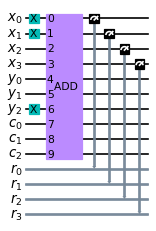

Traditional result: 3 + 4 = 7
Reversible circuit output:  0111


In [213]:
#===============================================================
# Test the 3-bit adder
#===============================================================
x0 = 3   # change this if you like
y0 = 4   # change this if you like
r = qiskit.ClassicalRegister (n+1, name='r')
C = qiskit.QuantumCircuit(x,y,c, r)
initRegister (C, x, x0)
initRegister (C, y, y0)
C.append (ADD, [*x,*y,*c])
C.measure (x, r)
fig,ax = plt.subplots (figsize=(7,4))
C.draw('mpl', justify='left', ax=ax, cregbundle=False); plt.show()
cir = C

sim = qiskit.Aer.get_backend('aer_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=1)
res = job.result()
cts = res.get_counts(exe)

print (f'Traditional result: {x0} + {y0} = {x0+y0}')
print (f'Reversible circuit output: ', list(cts.keys())[0] )

## Modular addition

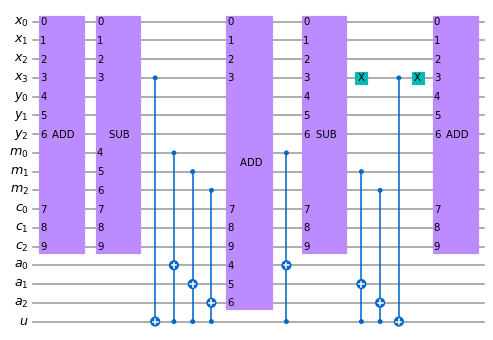

In [217]:
#===============================================================
# Build a circuit to do 3-bit modular addition (and call the instruction ADDMOD)
#===============================================================
n = 3        # Number of bits of y and m
x = qiskit.QuantumRegister(n+1,name='x')  # input register (addend) and output register (sum)
y = qiskit.QuantumRegister(n,name='y')    # input register (addend)
m = qiskit.QuantumRegister(n,name='m')    # input register (modulus)
c = qiskit.QuantumRegister(n,name='c')    # ancillas
a = qiskit.QuantumRegister(n,name='a')    # ancillas
u = qiskit.QuantumRegister(1,name='u')    # ancillas
C = qiskit.QuantumCircuit(x,y,m,c,a,u, name='                    ADDMOD                    ')
C.append (ADD, [*x,*y,*c])      # x += y  (using c as ancillas)
C.append (SUB, [*x,*m,*c])      # x -= m  (using c as ancillas)
C.cx (x[n], u)                  # u ^= (x<0)
for i in range(n):
  C.ccx (u, m[i], a[i])         # a ^= u * m
C.append (ADD, [*x,*a,*c])      # x += a  (using c as ancillas)
for i in range(n):
  C.ccx (u, m[i], a[i])         # a ^= u * m
C.append (SUB, [*x,*y,*c])      # x -= y (try modular subtraction)
C.x (x[n])                      # x[n] ^= 1
C.cx (x[n], u)                  # u ^= x[n]   (this serves to uncompute u)
C.x (x[n])                      # x[n] ^= 1
C.append (ADD, [*x,*y,*c])      # x += y  (using c as ancillas)
fig,ax=plt.subplots(1,1,figsize=(18,6)); C.draw('mpl',fold=-1,ax=ax,style=mystyle)
ADDMOD = C.to_instruction()

In [220]:
#===============================================================
# Test the 3-bit modular addition routine to see if it calculates (x+y)%m correctly
#===============================================================
x0 = 3   # change this if you like
y0 = 4   # change this if you like
m0 = 5   # change this if you like
r = qiskit.ClassicalRegister (n+1, name='r')
C = qiskit.QuantumCircuit(x,y,m,c,a,u, r)
initRegister (C, x, x0)  # addend
initRegister (C, y, y0)  # addend
initRegister (C, m, m0)  # modulus
C.append (ADDMOD, [*x,*y,*m,*c,*a,*u])
C.measure (x, r)
# fig,ax = plt.subplots (figsize=(10,7))
# C.draw('mpl', justify='left', ax=ax, cregbundle=False); plt.show()
cir = C

sim = qiskit.Aer.get_backend('aer_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=1)
res = job.result()
cts = res.get_counts(exe)

print (f'Traditional result: ({x0}+{y0})%{m0} = {(x0+y0)%m0}')
print (f'Reversible circuit output: ', list(cts.keys())[0] )

Traditional result: (3+4)%5 = 2
Reversible circuit output:  0010


## Deutsch algorithm

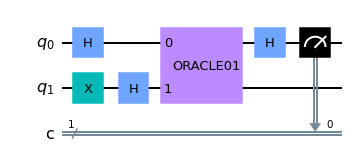

Oracle                        f(0)=0, f(1)=1
Constant(0) or balanced(1)    1
Deutsch algorithm output      {'1': 100}

The above code randomly chooses the oracle from 4 possibilities.
The output of the Deutsch algorithm should match the oracle type 100% of the time.


In [481]:
C=qiskit.QuantumCircuit(2,name='ORACLE00');                          O0=C.copy()
C=qiskit.QuantumCircuit(2,name='ORACLE01'); C.cx(0,1);               O1=C.copy()
C=qiskit.QuantumCircuit(2,name='ORACLE10'); C.x(0);C.cx(0,1);C.x(0); O2=C.copy()
C=qiskit.QuantumCircuit(2,name='ORACLE11'); C.x(1);                  O3=C.copy()
oracle = rng.integers(4)
ORACLE = [O0,O1,O2,O3] [oracle]
cir = qiskit.QuantumCircuit(2,1)
cir.h(0); cir.x(1); cir.h(1)
cir.compose (ORACLE, inplace=True, wrap=True)
cir.h(0); cir.measure([0],[0])
#======== Draw circuit
display( cir.draw('mpl') ) 
#======== Test circuit
exe=qiskit.transpile(cir,sim); job=sim.run(exe,shots=100); res=job.result(); cts=res.get_counts(exe)
print(f'Oracle                        f(0)={oracle>>1}, f(1)={oracle&1}')
print(f'Constant(0) or balanced(1)    {1 if oracle==1 or oracle==2 else 0}')
print(f'Deutsch algorithm output      {cts}')
print(f'\nThe above code randomly chooses the oracle from 4 possibilities.\nThe output of the Deutsch algorithm should match the oracle type 100% of the time.')

## Deutsch-Josza algorithm

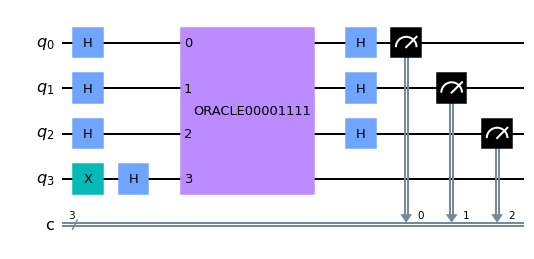

Oracle name                = ORACLE00001111
D-J algorithm output       = {'100': 256}

For a constant oracle, the D-J algorithm returns 000 in the classical register.
For a balanced oracle, the D-J algorithm returns some other value.


In [547]:
n = 3
ORACLES = []
C=qiskit.QuantumCircuit(n+1,name='ORACLE00000000');            ORACLES.append(C.copy())
C=qiskit.QuantumCircuit(n+1,name='ORACLE11111111'); C.x(3);    ORACLES.append(C.copy())
C=qiskit.QuantumCircuit(n+1,name='ORACLE00001111'); C.cx(2,3); ORACLES.append(C.copy())
C=qiskit.QuantumCircuit(n+1,name='ORACLE00110011'); C.cx(1,3); ORACLES.append(C.copy())
C=qiskit.QuantumCircuit(n+1,name='ORACLE01010101'); C.cx(0,3); ORACLES.append(C.copy())
oracle = rng.integers(len(ORACLES))
ORACLE = ORACLES[oracle]
cir = qiskit.QuantumCircuit(n+1,n)
cir.h(range(n)); cir.x(n); cir.h(n)
cir.compose (ORACLE, inplace=True, wrap=True)
cir.h(range(n)); cir.measure(range(n),range(n))
#======== Draw circuit
display( cir.draw('mpl') ) 
#======== Test circuit
exe=qiskit.transpile(cir,sim); job=sim.run(exe,shots=256); res=job.result(); cts=res.get_counts(exe)
print(f'Oracle name                = {ORACLE.name}')
#print(f'Constant(0) or balanced(1) = {0 if oracle<2 else 1}')
print(f'D-J algorithm output       = {cts}')
print ()
print ('For a constant oracle, the D-J algorithm returns 000 in the classical register.')
print ('For a balanced oracle, the D-J algorithm returns some other value.')

## Grover's algorithm

In [376]:
def ccccnot(c): # 0123=input, 4=input, 5=zeroed ancilla
  c.ccx(0,1,4); c.ccx(2,4,5); c.ccx(0,1,4); c.ccx(2,4,5); c.ccx(3,5,4)
  c.ccx(0,1,4); c.ccx(2,4,5); c.ccx(0,1,4); c.ccx(2,4,5); c.ccx(3,5,4)
def oracle(c):
  c.x(0);c.x(3);ccccnot(c);c.x(0);c.x(3)    # this is deliberately opaque
def grover(c):
  c.h(0);c.h(1);c.h(2);c.h(3);              # transform into Walsh basis
  c.x(0);c.x(1);c.x(2);c.x(3); ccccnot(c)   # flip bit 4 only if bits 0-3 are 0000 
  c.x(0);c.x(1);c.x(2);c.x(3);              # uncompute
  c.h(0);c.h(1);c.h(2);c.h(3);              # transform back

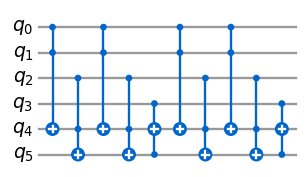

In [379]:
#===============================================================
# The circuit below implements the CCCCNOT gate.
#===============================================================
cir = qiskit.QuantumCircuit(6); ccccnot(cir); fig,ax=plt.subplots(1,1,figsize=(12,3)); cir.draw('mpl',ax=ax,style=mystyle)

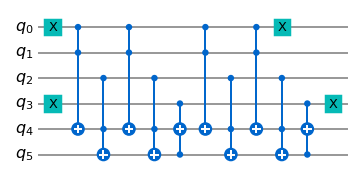

In [380]:
#===============================================================
# The circuit below implements an oracle function gate F.
# F flips q4 for a particular combination of q0,q1,q2,q3, but it's not obvious what that combination is.
#===============================================================
cir = qiskit.QuantumCircuit(6); oracle(cir); fig,ax=plt.subplots(1,1,figsize=(12,3)); cir.draw('mpl',ax=ax,style=mystyle)

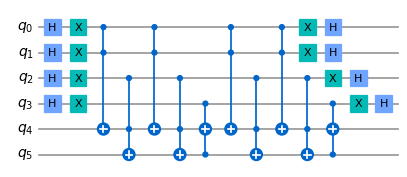

In [381]:
#===============================================================
# The circuit below performs the Grover operation G = W F_0 W
# where W is a Walsh transform and F_0 flips q4 if q0=q1=q2=q3=0.
#===============================================================
cir = qiskit.QuantumCircuit(6); grover(cir); fig,ax=plt.subplots(1,1,figsize=(12,3)); cir.draw('mpl',ax=ax,style=mystyle)

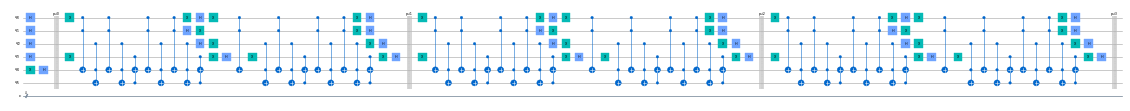

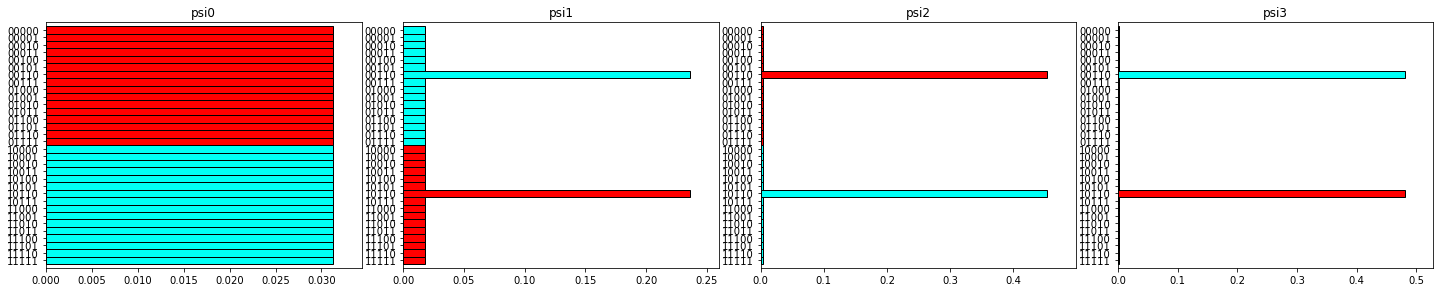

In [386]:
#======== Set up Grover circuit
cir = qiskit.QuantumCircuit(6,4)
cir.h ([0,1,2,3])         # put input register in uniform superposition
cir.x (4); cir.h (4)      # put output qubit in |-> state
cir.save_statevector(label=f'psi0')
for i in range(3):
  oracle(cir)             # apply oracle gate F
  grover(cir)             # apply Grover gate G
  cir.save_statevector(label=f'psi{i+1}')
fig,ax = plt.subplots(1,1,figsize=(20,4))
cir.draw('mpl',fold=-1,ax=ax,style=mystyle)
#======== Run
sim = qiskit.Aer.get_backend('statevector_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=100)
res = job.result()
cts = res.get_counts(exe)
psi = getStatevectors (res, 'psi')
psi = [psi[0:2**5] for psi in psi]
n = len(psi)
fig,axs = plt.subplots (1,n, figsize=(20,4)); fig.tight_layout() 
for i in range(n):
  plotStatevector (psi[i], ax=axs[i], vertical=True)
  axs[i].set_title (f'psi{i}')
  #axs[i].set_xlim ([0,1])

## Grover's algorithm with labeled instructions and registers

In [438]:
n = 4

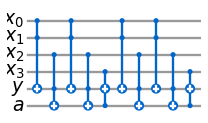

In [463]:
#===============================================================
# Define CCCCNOT, F (oracle), and G (Grover) gates
#===============================================================
x = qiskit.QuantumRegister(n,name='x')
y = qiskit.QuantumRegister(1,name='y')
a = qiskit.QuantumRegister(1,name='a')
C = qiskit.QuantumCircuit(x,y,a)
C.ccx(0,1,4); C.ccx(2,4,5); C.ccx(0,1,4); C.ccx(2,4,5); C.ccx(3,5,4)
C.ccx(0,1,4); C.ccx(2,4,5); C.ccx(0,1,4); C.ccx(2,4,5); C.ccx(3,5,4)
fig,ax=plt.subplots(1,1,figsize=(12,2)); C.draw('mpl',ax=ax,style=mystyle)
CCCCNOT = C

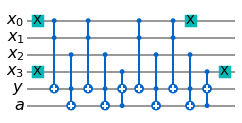

In [464]:
C = qiskit.QuantumCircuit(x,y,a,name='ORACLE\nF')
C.x(0);C.x(3)
C.ccx(0,1,4); C.ccx(2,4,5); C.ccx(0,1,4); C.ccx(2,4,5); C.ccx(3,5,4)
C.ccx(0,1,4); C.ccx(2,4,5); C.ccx(0,1,4); C.ccx(2,4,5); C.ccx(3,5,4)
C.x(0);C.x(3)
fig,ax=plt.subplots(1,1,figsize=(12,2)); C.draw('mpl',ax=ax,style=mystyle)
ORACLE = C

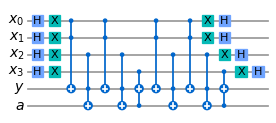

In [465]:
C = qiskit.QuantumCircuit(x,y,a,name='GROVER\nG')
C.h (x)                   # transform into Walsh basis
C.x (x)                   # uncompute
C.compose (CCCCNOT, inplace=True, qubits=[0,1,2,3,4,5])  # flip bit 4 only if bits 0-3 are 0000; use bit 5 as ancilla
C.x (x)                   # uncompute
C.h(range(n))             # transform back from Walsh basis
fig,ax=plt.subplots(1,1,figsize=(12,2)); C.draw('mpl',ax=ax,style=mystyle)
GROVER = C

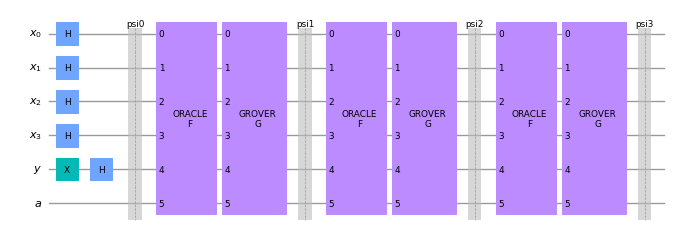

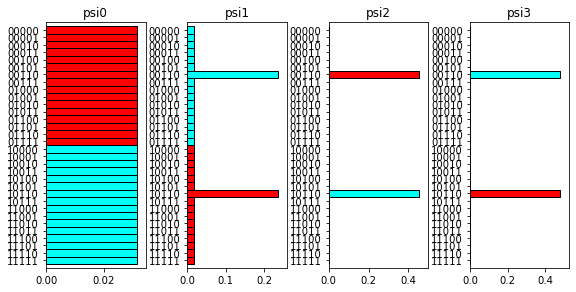

In [466]:
#======== Implement Grover's algorithm
numGroverIterations = 3
cir = qiskit.QuantumCircuit(x,y,a,name='full')
cir.h (range(n))          # put input register in uniform superposition
cir.x (n); cir.h (n)      # put output qubit in |-> state
cir.save_statevector(label=f'psi0')
for i in range(numGroverIterations):
  cir.compose (ORACLE, inplace=True, wrap=True)
  cir.compose (GROVER, inplace=True, wrap=True)
  cir.save_statevector(label=f'psi{i+1}')
fig,ax = plt.subplots(1,1,figsize=(12,4)); cir.draw('mpl',fold=-1,ax=ax,style=mystyle)
#======== Simulate statevector evolution
sim = qiskit.Aer.get_backend('statevector_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=100)
res = job.result()
cts = res.get_counts(exe)
psi = getStatevectors (res, 'psi')
psi = [psi[0:2**5] for psi in psi]
n = len(psi)
fig,axs = plt.subplots (1,n, figsize=(8,4)); fig.tight_layout() 
for i in range(n):
  plotStatevector (psi[i], ax=axs[i], vertical=True)
  axs[i].set_title (f'psi{i}')

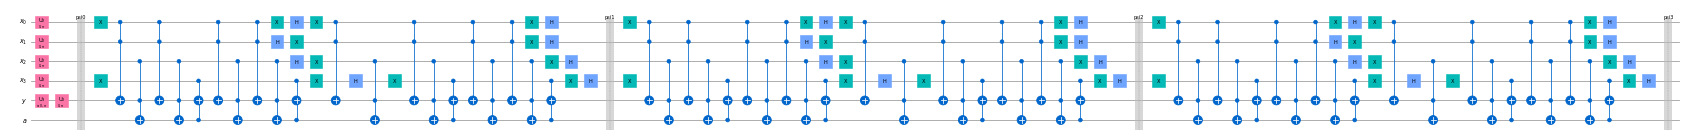

In [467]:
#======== Show all the gory details
fig,ax = plt.subplots(1,1,figsize=(30,4)); cir.decompose(reps=1).draw('mpl',fold=-1,ax=ax,style=mystyle)

## Quantum Fourier Transform (QFT)

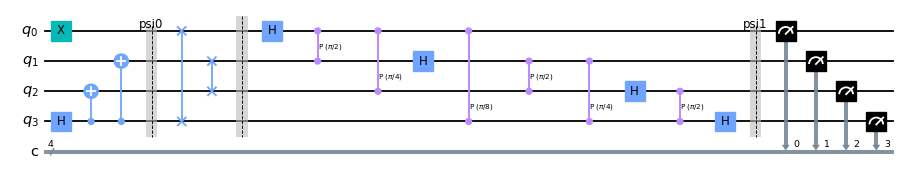

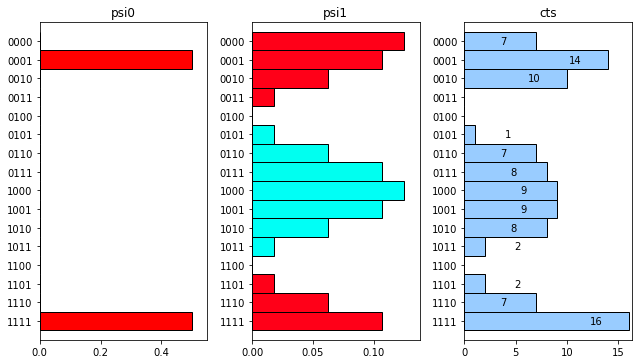

In [613]:
def initStates(cir,vals):
  if vals==0:        pass
  elif vals==1:      cir.x(0) 
  elif vals=='all':  cir.h(0); cir.h(1); cir.h(2); cir.h(3)
  elif vals==[1,15]: cir.h(3); cir.cx(3,2); cir.cx(3,1); cir.x(0)
  elif vals==[2,14]: cir.h(3); cir.cx(3,2); cir.x(1)
  elif vals==[3,13]: cir.h(3); cir.cx(3,2); cir.cx(3,1); cir.x(1); cir.x(0)
  elif vals==[4,12]: cir.h(3); cir.x(2)
  
#======== Build and draw circuit
cir = qiskit.QuantumCircuit(4,4)
initStates (cir,[1,15])                         # Change this if you like
cir.save_statevector(label='psi0')
cir.swap(0,3); cir.swap(1,2)                    # Bit-reversal permutation
cir.barrier()
cir.h(0); cir.cp(np.pi/2, 1,0); cir.cp(np.pi/4, 2,0); cir.cp(np.pi/8, 3,0)
cir.h(1); cir.cp(np.pi/2, 2,1); cir.cp(np.pi/4, 3,1)
cir.h(2); cir.cp(np.pi/2, 3,2)
cir.h(3)
cir.save_statevector(label='psi1')
cir.measure([0,1,2,3],[0,1,2,3])
fig,ax = plt.subplots (figsize=(24,3))
cir.draw('mpl', fold=-1, justify='left', ax=ax); plt.show()
#======== Run
sim = qiskit.Aer.get_backend('statevector_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=100)
res = job.result()
cts = res.get_counts(exe)
psi = getStatevectors (res, 'psi')
fig,axs = plt.subplots (1,3, figsize=(9,5)); fig.tight_layout() 
ax=axs[0]; plotStatevector(psi[0],ax=ax,vertical=True); ax.set_title ('psi0')
ax=axs[1]; plotStatevector(psi[1],ax=ax,vertical=True); ax.set_title ('psi1')
ax=axs[2]; plotHistogram(cts,ax=ax,vertical=True); ax.set_title ('cts');

## Quantum Phase Estimation (QPE)

### Quantum phase estimation for $N=5$ time qubits and $M=1$ system qubits

Consider a quantum system that consists of a single orbital with energy $E_0$ that can be occupied by one particle.  The Hamiltonian is

$\qquad$
$\hat{H} = 0 \ket{0} \bra{0} +  E_0 \ket{1} \bra{1} = E_0 \adag a$.
    
Consider the time evolution of the system during a timestep $t$.  The time evolution operator is $\hat{U} = e^{-i\hat{H} t/\hbar}$.  This means that:
- If $\ket{\psi} = \ket{0}$, the orbital is empty, the system energy is 0, and the phase changes by a factor 1.  
- If $\ket{\psi} = \ket{1}$, the orbital is occupied, the system energy is $E_0$, and the phase changes by a factor $e^{2\pi f_0}$ where $E_0 = hf_0$.

The statevector evolves according to the unitary matrix below.  This is simply a phase gate, whose eigenvalues are $1$ and $e^{2\pi i f_0}$:

$\hspace{1cm}$
$\underline{\underline{\mathbf{U}}}
= \underline{\underline{\mathbf{P}}} (2\pi f_0)
= \pmatrix{1&0\\0&e^{2\pi i f_0}}$.

To use the Quantum Phase Estimation algorithm, we need to implement a controlled version of the timestep evolution operator.  We can do this using a controlled phase gate, as shown below:

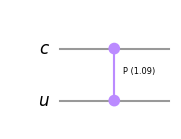

In [636]:
freq = 5.57/32                       # 
nmax = 5                             # number of "control" qubits
mmax = 1                             # number of "system" qubits
#======== Define controlled timestep evolution operation for system being considered
c = qiskit.QuantumRegister(1,'c')    # control bit
u = qiskit.QuantumRegister(mmax,'u') # target register
CU = qiskit.QuantumCircuit(c,u,name='CU')
CU.cp(2*np.pi*freq, c, u);
fig,ax = plt.subplots(figsize=(3,6))
CU.draw('mpl',justify='left',fold=-1,ax=ax,style=mystyle)

The above operation will be represented by a box labeled "CU".  The circuit below implements Quantum Phase Estimation (QPE).  Observe what happens.

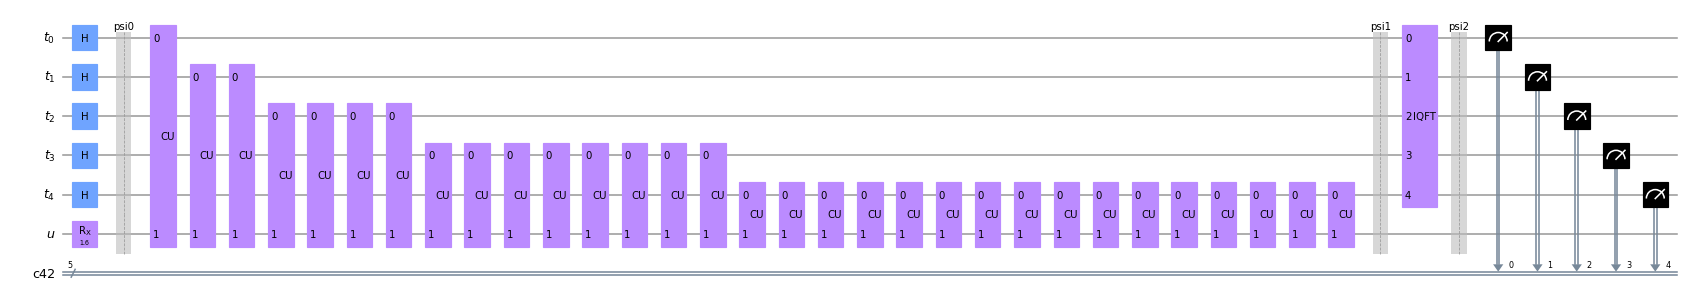

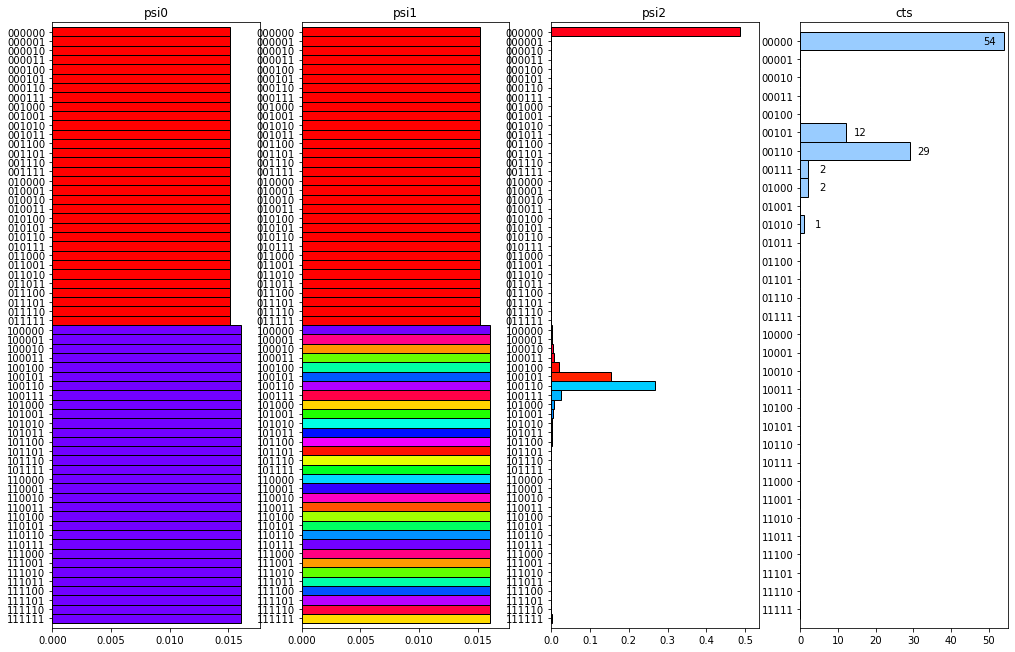

In [637]:
#======== Set up quantum phase estimation circuit
t = qiskit.QuantumRegister(nmax,name='t')   # "control" register
u = qiskit.QuantumRegister(mmax,name='u')   # "system" register
r = qiskit.ClassicalRegister(nmax)          # "result" register
cir = qiskit.QuantumCircuit(t,u,r)
cir.h(t)          # Set up "control" register with initial Hadamard gates
cir.rx(1.6, u)    # Set up "state" register with guess at eigenvector
cir.save_statevector ('psi0')
for n in range(nmax):
  for i in range(2**n): 
    cir.compose (CU, [t[n],*u], inplace=True, wrap=True)   # Controlled unitary gates
cir.save_statevector ('psi1')
cir.append (qiskit.circuit.library.QFT(nmax).inverse(), t) # Quantum Fourier transform
cir.save_statevector ('psi2')
cir.measure (t,r)
fig,ax = plt.subplots(figsize=(30,6))
cir.draw('mpl',justify='left',fold=-1,ax=ax,style=mystyle)
#======== Run simulation and plot histogram of results
sim = qiskit.Aer.get_backend('statevector_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=100)
res = job.result()
cts = res.get_counts(exe)
psi = getStatevectors (res, 'psi')
fig,axs = plt.subplots (1,4, figsize=(14,9)); fig.tight_layout() 
ax=axs[0]; plotStatevector(psi[0],ax=ax,vertical=True); ax.set_title ('psi0')
ax=axs[1]; plotStatevector(psi[1],ax=ax,vertical=True); ax.set_title ('psi1')
ax=axs[2]; plotStatevector(psi[2],ax=ax,vertical=True); ax.set_title ('psi2')
ax=axs[3]; plotHistogram(cts,ax=ax,vertical=True); ax.set_title ('cts');

In the above figure:
- We prepare $\ket{\psi_0}$, where $\ket{t}$ is in a uniform superposition, and $\ket{u}$ is hopefully close to an eigenvector.
- We obtain $\ket{\psi_1}$ by evolving $\ket{u}$ by $\ket{t}$ timesteps.
- We obtain $\ket{\psi_2}$ by doing an IQFT.  Now the control register contains the spectrum of the Hamiltonian.  The basis states represent different frequencies $f$.
- Measuring the control register collapses the statevector to one of the dominant spectral frequencies.

If we run the QPE algorithm many times, we find that the most common measured values of $f$ are $f_0 = 0$ and $f_1 = 6/32$.  These numbers are indeed close to the eigenvalues of the phase gate, which are 0 and 5.57/32.

### Quantum phase estimation for $N=5$ and $M=3$

Consider the following quantum Hamiltonian, which describes boson(s) hopping on a triangle threaded by a magnetic field:

$\newcommand{\aaaa}{a^{\vphantom{\phd}}}$
$\qquad$
$
\begin{align}
\hat{H} 
&= 
    \Delta 
    -J   \big( \ket{1}\bra{0} + \ket{2}\bra{1} + \ket{0}\bra{2} \big)
    -J^* \big( \ket{0}\bra{1} + \ket{1}\bra{2} + \ket{2}\bra{3} \big)
    \\
&=
    \Delta 
    -J   (\adag_1 \aaaa_0 + \adag_2 \aaaa_1 + \adag_0 \aaaa_2) 
    -J^* (\adag_0 \aaaa_1 + \adag_1 \aaaa_2 + \adag_2 \aaaa_0) 
\end{align}$

where $\Delta = \frac{2\pi}{3}$.
and $J=\frac{2\pi}{\sqrt{27}} e^{-i\pi/6}$.
Consider time evolution by a timestep $t=1$.  
In the one-particle subspace, which is a 3D Hilbert space, one finds that the time evolution operator is a cyclic permutation:

$\qquad$
$\underline{\underline{\mathbf{H}}} =
\pmatrix{\Delta & -J^* & -J \\ -J & \Delta & -J^* \\ -J^* & -J & \Delta}$,
$\qquad$
$\underline{\underline{\mathbf{U}}} = \pmatrix{0&0&1\\1&0&0\\0&1&0}$.

It can be shown that the eigenvalues of the time-evolution operator are the cube roots of unity: $\lambda = 1, e^{2\pi i/3}, e^{-2\pi i/3}$.

By symmetry, one may deduce that the second-quantized Hamiltonian in the 8D Hilbert space has eigenvalues $\lambda = 1, e^{2\pi i/3}, e^{-2\pi i/3}$ with degeneracies $(4,2,2)$ respectively.  I believe it can be shown that the time-evolution operator can be written in terms of two swap gates,

$\qquad$
$\underline{\underline{\mathbf{U}}} = \underline{\underline{\mathbf{S}}}_{01} \underline{\underline{\mathbf{S}}}_{12}$,
$\qquad$
$\underline{\underline{\mathbf{S}}}_{12} = 
\underline{\underline{\mathbf{X}}}_{12}
\underline{\underline{\mathbf{X}}}_{21}
\underline{\underline{\mathbf{X}}}_{12}
$.

Let us apply QPE to this time-evolution operator.  We need a controlled version of our U operator, CU.  Simply replace each SWAP gate by a CSWAP gate:

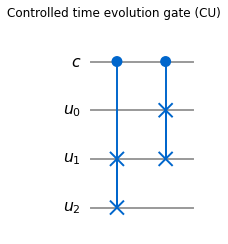

In [707]:
nmax = 5                             # number of "control" qubits
mmax = 3                             # number of "system" qubits
#======== Define controlled timestep evolution operation for system being considered
c = qiskit.QuantumRegister(1,'c')    # control bit
u = qiskit.QuantumRegister(mmax,'u') # target register
CU = qiskit.QuantumCircuit(c,u,name='CU')
CU.cswap (c, u[2], u[1]);
CU.cswap (c, u[1], u[0]);
fig,ax = plt.subplots(figsize=(3,6))
CU.draw('mpl',justify='left',fold=-1,ax=ax,style=mystyle); plt.title('Controlled time evolution gate (CU)');

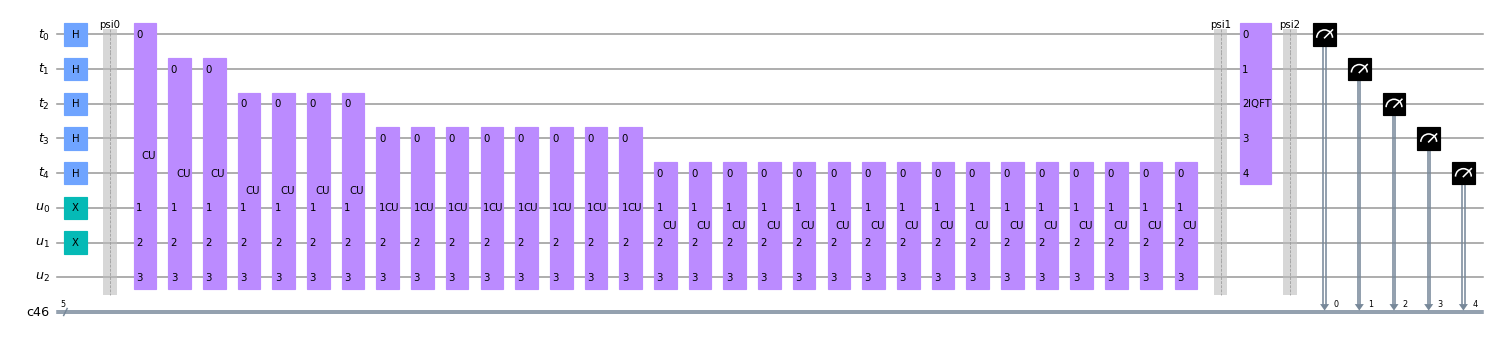

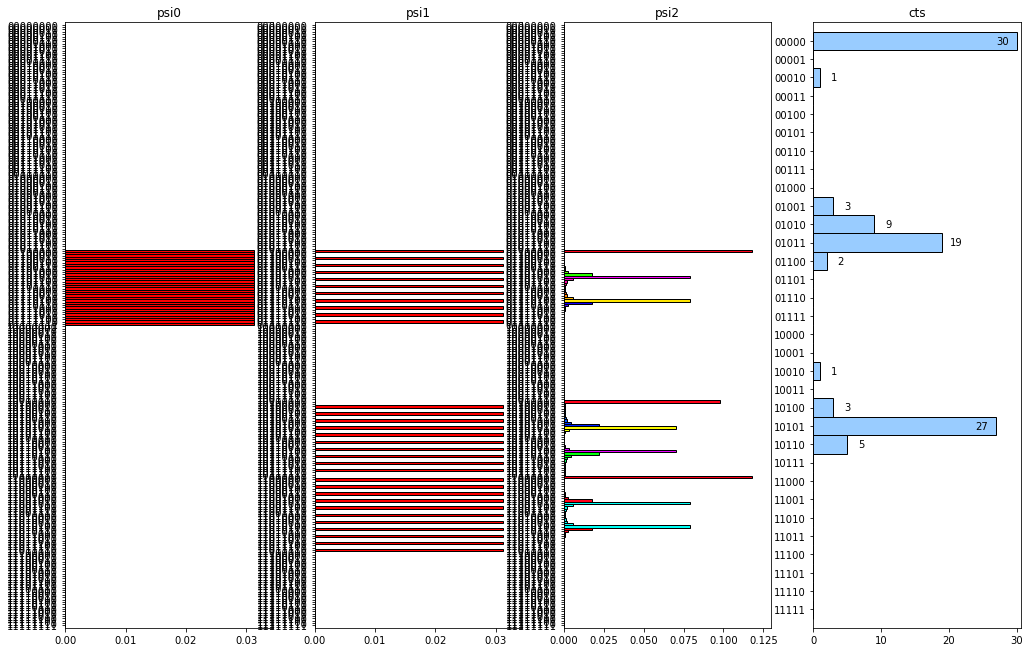

In [708]:
#======== Set up quantum phase estimation circuit
t = qiskit.QuantumRegister(nmax,name='t')   # "control" register
u = qiskit.QuantumRegister(mmax,name='u')   # "system" register
r = qiskit.ClassicalRegister(nmax)          # "result" register
cir = qiskit.QuantumCircuit(t,u,r)
cir.h(t)                   # Set up "control" register with initial Hadamard gates
cir.x(u[0]); cir.x(u[1])   # Set up "state" register as |011> rather arbitrarily
cir.save_statevector ('psi0')
for n in range(nmax):
  for i in range(2**n): 
    cir.compose (CU, [t[n],*u], inplace=True, wrap=True)   # Controlled unitary gates
cir.save_statevector ('psi1')
cir.append (qiskit.circuit.library.QFT(nmax).inverse(), t) # Quantum Fourier transform
cir.save_statevector ('psi2')
cir.measure (t,r)
fig,ax = plt.subplots(figsize=(30,6))
cir.draw('mpl',justify='left',fold=-1,ax=ax,style=mystyle)
#======== Run simulation and plot histogram of results
sim = qiskit.Aer.get_backend('statevector_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=100)
res = job.result()
cts = res.get_counts(exe)
psi = getStatevectors (res, 'psi')
fig,axs = plt.subplots (1,4, figsize=(14,9)); fig.tight_layout() 
ax=axs[0]; plotStatevector(psi[0],ax=ax,vertical=True); ax.set_title ('psi0')
ax=axs[1]; plotStatevector(psi[1],ax=ax,vertical=True); ax.set_title ('psi1')
ax=axs[2]; plotStatevector(psi[2],ax=ax,vertical=True); ax.set_title ('psi2')
ax=axs[3]; plotHistogram(cts,ax=ax,vertical=True); ax.set_title ('cts');

We have predicted that the eigenvalues of the $U$ operator are the cube roots of unity.  In other words, the eigenfrequencies should be $0$, $1/3$, and $2/3$.  

Indeed, QPE gives a frequency spectrum with three peaks corresponding to integer frequencies $f=0, 11, 21$, which represent physical frequencies $f=0, 11/32, 21/32$.  These are the best 5-bit binary approximations to $0$, $1/3$, and $2/3$.

## Shor's Algorithm

In [3]:
def QFT(n):
  C = qiskit.QuantumCircuit(n, name='    QFT    ')
  for i in reversed(range(n)):
    C.h (i)
    for j in range(i):
      C.cp (np.pi/2**(j+1), i-1-j, i)
  for i in range(n//2): 
    C.swap (i, n-1-i)
  return C.to_instruction()

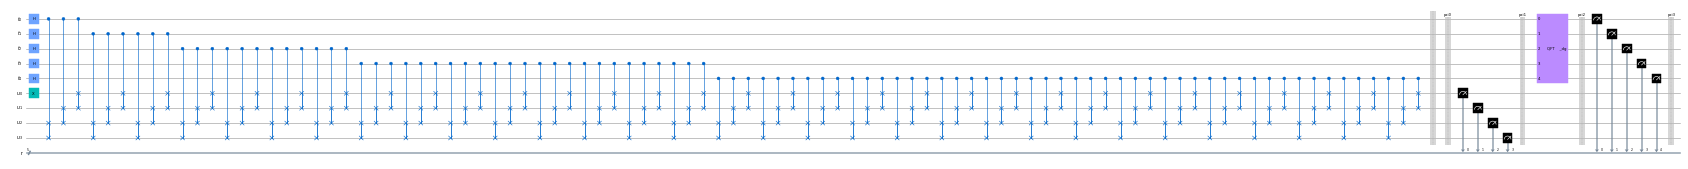

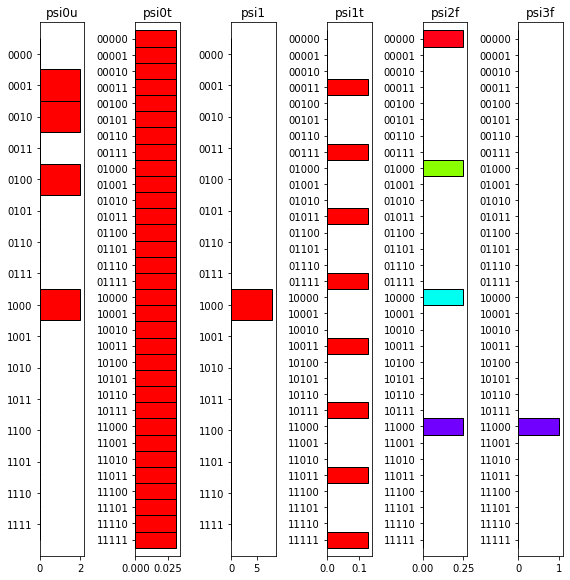

In [4]:
N = 5
M = 4
t = qiskit.QuantumRegister (N, name='t')
u = qiskit.QuantumRegister (M, name='u')
r = qiskit.ClassicalRegister (N, name='r') # results
cir = qiskit.QuantumCircuit (t, u, r)
cir.h (t)
cir.x (u[0])

for n in range(N):
  for iter in range(2**n):
    cir.cswap (t[n], u[3], u[2])
    cir.cswap (t[n], u[2], u[1])
    cir.cswap (t[n], u[1], u[0])
cir.barrier()
cir.save_statevector ('psi0')

cir.measure (u, r[:M])
cir.save_statevector ('psi1')

cir.append (QFT(N).inverse(), t)
cir.save_statevector ('psi2')

cir.measure (t, r[:N])
cir.save_statevector ('psi3')

fig,ax = plt.subplots(figsize=(30,6))
cir.draw('mpl',justify='left',fold=-1,ax=ax,style=mystyle)

#======== Run simulation and plot histogram of results
sim = qiskit.Aer.get_backend('statevector_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=1)
res = job.result()
cts = res.get_counts(exe)
psi = getStatevectors (res, 'psi') 
psi0u = np.sum( psi[0].reshape ([2**M,2**N]) , axis=1)
psi0t = np.sum( psi[0].reshape ([2**M,2**N]) , axis=0)
psi1u = np.sum( psi[1].reshape ([2**M,2**N]) , axis=1)
psi1t = np.sum( psi[1].reshape ([2**M,2**N]) , axis=0)
psi2f = np.sum( psi[2].reshape ([2**M,2**N]) , axis=0)
psi3f = np.sum( psi[3].reshape ([2**M,2**N]) , axis=0) # ignore u
psi = [psi0u, psi0t, psi1u, psi1t, psi2f, psi3f]  # heterogeneous list

m = len(psi)
fig,axs = plt.subplots (1,m, figsize=(8,8)); fig.tight_layout(w_pad=2) 
# for i in range(m):
i=0; plotStatevector (psi[i], ax=axs[i], vertical=True, tickInterval=1); axs[i].set_title (f'psi0u')
i=1; plotStatevector (psi[i], ax=axs[i], vertical=True, tickInterval=1); axs[i].set_title (f'psi0t')
i=2; plotStatevector (psi[i], ax=axs[i], vertical=True, tickInterval=1); axs[i].set_title (f'psi1')
i=3; plotStatevector (psi[i], ax=axs[i], vertical=True, tickInterval=1); axs[i].set_title (f'psi1t')
i=4; plotStatevector (psi[i], ax=axs[i], vertical=True, tickInterval=1); axs[i].set_title (f'psi2f');
i=5; plotStatevector (psi[i], ax=axs[i], vertical=True, tickInterval=1); axs[i].set_title (f'psi3f');

The above circuit shows roughly how Shor's algorithm works, in the case where the base is $b=2$, the modulus is $m=15$, and the exponent $t$ is a 5-bit integer.
1. **Use Hadamard gates** to put the control/time/frequency register into a uniform superposition $\sum_{t=0}^{2^N-1} \ket{t}$.
2. **Compute $u = 2^t \mathrm{~mod~} 15$.  This produces an entangled state $\sum_{t=0}^{2^N-1} \ket{t} \otimes \ket{2^t \mathrm{~mod~} 15}$.**  At this point the statevector is $\psi_0$.  The first two columns show $\psi_0$ projected onto $u$ and $t$ registers respectively (psi0u and psi0t).  We see that $u$ is in a superposition of 4 possibilities (1, 2, 4, 8), and $t$ is in a superposition of $2^N$ possibilities.

3. **Measure $u$.**  Now the statevector is $\psi_1$.  This is visualized as psi1u and psi1t.  Te measurement has picked out a SINGLE value of $u$ (1, 2, 4, or 8).  The values of $t$ are now restricted.  The statevector has the form of a *shifted comb*.

4. **Do an inverse QFT on the $t$ register.**  Now the statevector is $\psi_2$.  See psi2f.  The IQFT has transformed the *shifted comb* in the $t$ domain to an *unshifted comb* in the $f$ domain.

5. **Measure the control register $t$.**  At this point the control register really represents frequency, rather than time.  See psi3f.  The measurement has picked out one of the teeth of the unshifted comb.  We will call this $f$.  

From this point onward the algorithm is classical.  Take the integer frequency $f$ and convert it to a physical frequency by dividing by $2^N$.  In the case of the function $u = 2^t \mathrm{~mod~} 15$, we will find one of four results for the physical frequency: $0, 1/4, 1/2$, or $3/4$.  This allows us to deduce that the fundamental frequency is $f_1 = 1/4$, and that the period of the function is $T = 4$.

If the period $T$ is even, compute $p = \text{GCD} (a^{T/2} + 1, m)$.  This is likely to be a factor of $m$.  For example:

$\quad$$a=2 \implies u=1,2,4,8,1,2,\dots \implies T=4 \implies  p = \text{GCD} (2^{4/2} + 1, 15) = 5$

$\quad$$a=3 \implies u=1,3,9,12,6,3,\dots \implies T=4 \implies  p = \text{GCD} (2^{4/2} + 1, 15) = 5$

$\quad$$a=4 \implies u=1,4,1,4,1,4,\dots \implies T=2 \implies  p = \text{GCD} (2^{2/2} + 1, 15) = 3$

$\quad$$a=5 \implies u=1,5,10,5,10,\dots \implies T=2 \implies  p = \text{GCD} (2^{2/2} + 1, 15) = 3$

$\quad$$a=6 \implies u=1,6,6,6,6,6,\dots \implies T=1$ (odd, so not useful)

This suggests that 3 and 5 are factors of 15.

### Important discussion!

The above implementation of Shor's algorithm calculates $u = b^t \mathrm{~mod~} m$ using **exponentiation by repeated multiplication**, where $t=0,\dots,2^N-1$.  With this simple method, the number of gates is $O(2^N)$.  (You can see that the circuit uses a large number of gates.)  This does NOT give a speedup over classical algorithms.

In order to get a quantum speedup, one needs to calculate $u = b^t \mathrm{~mod~} m$ using **exponentiation by squaring**.  This requires extra ancillary registers, but it reduces the number of gates to $O(N)$.  That implementation of Shor's algorithm would give exponential quantum speedup over classical algorithms.
